<a href="https://colab.research.google.com/github/patiegm/Datasci_Resources/blob/master/TorchCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading and understanding data

CIFAR10 is a dataset of images: 10 classes, 50000 images total. The classes are: airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck

In [0]:
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

CUDA_AVAILABLE = torch.cuda.is_available()

In [0]:
# if False, you're using CPU
# if True, you're on GPU

CUDA_AVAILABLE

True

In [0]:
# Define transformations that will need to be
# performed on data upon loading
transform = transforms.Compose(
    [transforms.ToTensor(),  # turn into Torch's data format
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))])  # normalise to a given mean


# Download and import data
train_data = torchvision.datasets.CIFAR10(root="./", transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform)

# prepare objects that feed the data to the neural network
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=4)

0it [00:00, ?it/s]

100%|█████████▉| 170311680/170498071 [00:43<00:00, 2427262.15it/s]

In [0]:
train_data.data.shape
# 50000 images, 32x32, 3 color channels

(50000, 32, 32, 3)

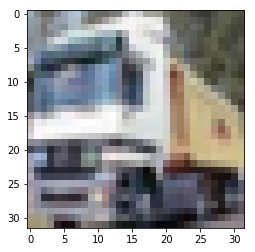

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# example image
plt.imshow(train_data.data[1])

In [0]:
print(train_data.classes)
n_classes = len(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Building a neural network with Torch

In [0]:
# define a neural network as a sequence of layers
# (more complicated cases can exist)

model = nn.Sequential(
    # a 3 by 3 convolution layer with 16 filters
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), 
    # nonlinearity: rectified linear unit
    nn.ReLU(),  
    # max pooling layer
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), 
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3), 
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(in_channels=32, out_channels=n_classes, kernel_size=2, padding=0)
    )

# transfer the model to the GPU (general purpose graphics card)
if CUDA_AVAILABLE:
    model.cuda()

In [0]:
from torch.optim import Adam
from torch.autograd import Variable

# define the "optimizer", which updates the parameters based on the gradients
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()


# start the training
train_losses = []
for i in range(20):
    train_loss = 0.0

    for (images, labels) in train_loader:
        # transfer variables to GPU
        if CUDA_AVAILABLE:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # generate the network's output
        predictions = model(images).squeeze()

        # compare the output with the training labels
        error = loss_fn(predictions, labels)
        
        # store the error value (for evaluation)
        train_loss += error.cpu().data.numpy()

        # reset the gradients
        optimizer.zero_grad()
        
        # do backpropagation
        error.backward()

        # update the parameters based on the gradients
        optimizer.step()
        
    train_loss = train_loss / 50000
    print(train_loss)
    train_losses.append(train_loss)

0.006926430621147156
0.006858773647546768
0.006780646344423294
0.006693394029140472
0.006642882673740387
0.006581364858150482
0.006538210439682007
0.006504810341596603
0.006432474389076233
0.006375634610652924
0.006321433429718018
0.006237277069091797
0.006223052281141281
0.006194546127319336
0.006158451741933822
0.006115234926342964
0.0060569893884658815
0.0060410363566875454
0.00599142804980278
0.005971460539102555


Text(0.5, 0, 'Time (training epochs)')

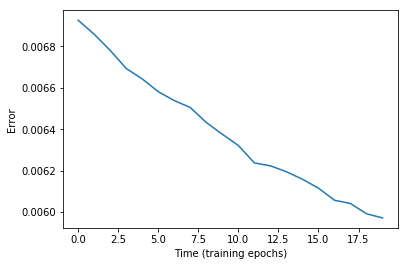

In [0]:
# plot how the error evolved in time
plt.plot(train_losses)
plt.ylabel("Error")
plt.xlabel("Time (training epochs)")

airplane 	 2.3213038
automobile 	 3.7458932
bird 	 -4.1568313
cat 	 -4.381301
deer 	 -2.091555
dog 	 -6.824186
frog 	 -5.79365
horse 	 -5.4370117
ship 	 2.0101748
truck 	 0.18744484


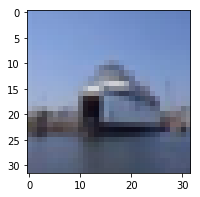

In [0]:
# testing

for i, (images, labels) in enumerate(test_loader):
    # transfer variables to GPU
    if CUDA_AVAILABLE:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
    
    # plot the image
    plt.figure(figsize=(3,3))
    image = (images.squeeze().cpu().transpose(0,2).transpose(0,1) + 1.0)/2.
    plt.imshow(image)

    # forward pass (run image through the model)
    outputs = model(images)
    outputs_npy = outputs.squeeze().cpu().detach().numpy()
    for i in range(n_classes):
        print(test_data.classes[i], '\t', outputs_npy[i])
    

    break

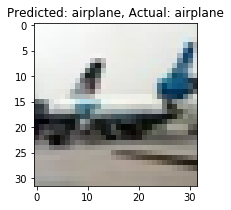

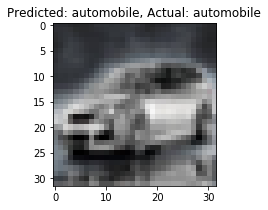

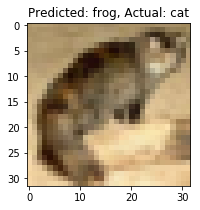

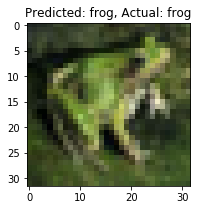

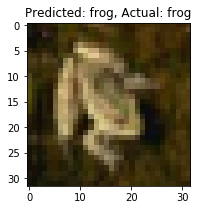

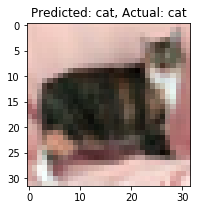

In [0]:
# testing

for i, (images, labels) in enumerate(test_loader):
    # transfer variables to GPU
    if CUDA_AVAILABLE:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

    # forward pass (run image through the model)
    outputs = model(images)
    
    # look for the class that has the highest probability
    _,prediction = torch.max(outputs, 1)    
    label = labels.cpu().numpy().squeeze()
    
    # plot
    plt.figure(figsize=(3,3))
    image = (images.squeeze().cpu().transpose(0,2).transpose(0,1) + 1.0)/2.
    plt.imshow(image)
    prediction = prediction.cpu().numpy().squeeze()
    plt.title(f"Predicted: {test_data.classes[prediction]}, Actual: {test_data.classes[label]}")
    
    if i >= 5: break